In [1]:
##### import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
from skimage.feature import hog
from sklearn.utils import shuffle

import pandas as pd  
from keras.models import Sequential
from keras.models import Model
from keras.layers import ELU
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Lambda
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2
from keras.models import model_from_json

from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

import simplejson as json
import random

Using TensorFlow backend.


In [2]:
imgRow = 630
imgCol = 960

In [3]:
def showGrayImage(img):
    imgShow = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    
    imgShow[:,:,2] = imgShow[:,:,0]*255
    imgShow[:,:,0:2] = 0    
    
    plt.imshow(imgShow)            
    plt.show()

In [4]:
rootDir = "object-detection-crowdai/"
csvFile = pd.read_csv(rootDir+'labels.csv', header=0)

dataFile = csvFile[(csvFile['Label']!='Pedestrian')].reset_index()
dataFile = dataFile.drop('index', 1)
dataFile = dataFile.drop('Preview URL', 1)
dataFile['Frame'] = './' + rootDir + dataFile['Frame']
dataFile.columns = ['xmin', 'ymin', 'xmax','ymax', 'Frame', 'Label']
dataFile.head(10)

,xmin,ymin,xmax,ymax,Frame,Label
0,785,533,905,644,./object-detection-crowdai/1479498371963069978...,Car
1,89,551,291,680,./object-detection-crowdai/1479498371963069978...,Car
2,268,546,383,650,./object-detection-crowdai/1479498371963069978...,Car
3,455,522,548,615,./object-detection-crowdai/1479498371963069978...,Truck
4,548,522,625,605,./object-detection-crowdai/1479498371963069978...,Truck
5,1726,484,1919,646,./object-detection-crowdai/1479498371963069978...,Car
6,758,557,807,617,./object-detection-crowdai/1479498371963069978...,Car
7,633,561,680,597,./object-detection-crowdai/1479498371963069978...,Car
8,682,557,718,593,./object-detection-crowdai/1479498371963069978...,Car
9,710,540,836,665,./object-detection-crowdai/1479498372942264998...,Car


In [5]:
def CropImage(image):
    #Crops the iamge so that the hood of the car and top of the image
    #which contains sky trees and other stuffs are removed.
    height = len(image)
    return image[int(height * 2/5.):int(height * 6/7.0), :, :]

288.0
(1200, 1920, 3)


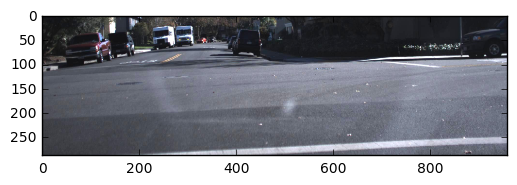

(288, 960, 3)


In [6]:

dataInfo = dataFile
print((imgRow*6)/7-(imgRow*2)/5)                        
row = 0#np.random.randint(len(dataInfo))
fileName = dataInfo['Frame'][row]
# print(fileName, row)
img = cv2.imread(fileName)
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (imgCol, imgRow))

img = CropImage(img)
plt.imshow(img)
plt.show()
print(img.shape)

In [7]:
names = ['Frame',  'xmin', 'ymin', 'xmax','ymax', 'occluded', 'Label']
rootDir = "object-dataset/"
csvFile1 = pd.read_csv(rootDir+'labels.csv', delim_whitespace=True, names=names)
dataFile1 = csvFile1[(csvFile1['Label']!=str.lower('Pedestrian'))].reset_index()
dataFile1 = dataFile1.drop('index',1)
dataFile1 = dataFile1.drop('occluded',1)
dataFile1['Frame'] = './' + rootDir + dataFile1['Frame']
dataFile1.tail(10)


,Frame,xmin,ymin,xmax,ymax,Label
83210,./object-dataset/1478901535817639152.jpg,162,598,404,754,car
83211,./object-dataset/1478901535817639152.jpg,400,592,506,714,car
83212,./object-dataset/1478901535817639152.jpg,1118,556,1346,740,car
83213,./object-dataset/1478901536388465963.jpg,234,594,388,728,car
83214,./object-dataset/1478901536388465963.jpg,364,604,430,678,car
83215,./object-dataset/1478901536388465963.jpg,1048,552,1348,748,car
83216,./object-dataset/1478901536960505700.jpg,0,606,142,780,car
83217,./object-dataset/1478901536960505700.jpg,146,604,246,692,car
83218,./object-dataset/1478901536960505700.jpg,710,582,800,618,car
83219,./object-dataset/1478901536960505700.jpg,896,546,1228,790,car


In [8]:
dataFile.tail()

,xmin,ymin,xmax,ymax,Frame,Label
66384,958,559,1045,621,./object-detection-crowdai/1479506176491553178...,Car
66385,1038,558,1122,630,./object-detection-crowdai/1479506176491553178...,Car
66386,667,558,747,626,./object-detection-crowdai/1479506176491553178...,Car
66387,730,568,818,613,./object-detection-crowdai/1479506176491553178...,Car
66388,435,551,532,589,./object-detection-crowdai/1479506176491553178...,Car


In [15]:
from keras.models import model_from_json

with open('model.json', 'r') as jfile:
    model = model_from_json(json.loads(jfile.read())) 
    print('model loaded')

model.compile(optimizer=Adam(lr=1e-4), loss="mse", metrics=['accuracy'])
weights_file = 'model.h5'
model.load_weights(weights_file)


#result = cv2.addWeighted(dst, 1, newwarp, 0.3, 0)

model loaded


./object-dataset/1478020231192141988.jpg 766
Original image


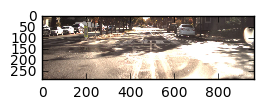

Predicted segmentation mask


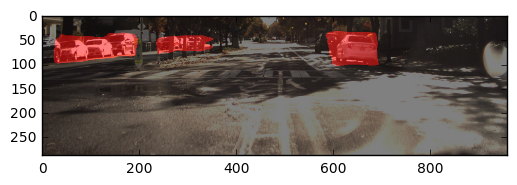

Ground truth BB


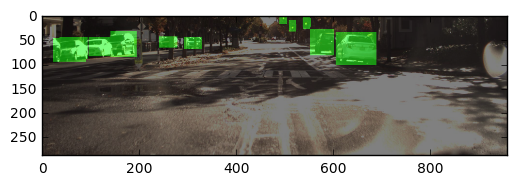

In [16]:
train_samples_per_epoch = 2560
valid_samples_per_epoch = 16384
trainBatchSize = 16
validationBatchSize = 64

def TrainDataGenerator(dataInfoList,batchSize,rootDir):
    batch_x, batch_y = [], []
    while True:
        dataInfo = dataInfoList[random.randint(0,1)]
        row = np.random.randint(len(dataInfo))
        fileName = dataInfo['Frame'][row]
        print(fileName, row)
        img = cv2.imread(fileName)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        origShape = img.shape
        img = cv2.resize(img, (imgCol, imgRow))
        
        data = dataInfo[dataInfo['Frame'][row] == dataInfo['Frame']].reset_index()
        data['xmin'] = np.round(data['xmin'] / origShape[1] * imgCol)
        data['xmax'] = np.round(data['xmax'] / origShape[1] * imgCol)
        data['ymin'] = np.round(data['ymin'] / origShape[0] * imgRow)
        data['ymax'] = np.round(data['ymax'] / origShape[0] * imgRow)
        img1 = img.copy()
        '''targetImg = np.reshape(np.zeros_like(img[:, :, 2]), (imgRow, imgCol, 1))
        for i in range(len(data)):
            targetImg[data.iloc[i]['ymin']:data.iloc[i]['ymax'], data.iloc[i]['xmin']:data.iloc[i]['xmax']] = 1
            cv2.rectangle(img1, (int(data.iloc[i]['xmin']),int(data.iloc[i]['ymin'])), (int(data.iloc[i]['xmax']),int(data.iloc[i]['ymax'])), (0,0,255),6)'''
        
        targetImg = np.zeros_like(img[:, :, 2])
        for i in range(len(data)):
            targetImg[data.iloc[i]['ymin']:data.iloc[i]['ymax'], data.iloc[i]['xmin']:data.iloc[i]['xmax']] = 1

        targetImg = np.reshape(targetImg, (imgRow, imgCol, 1))        
        targetImg = CropImage(targetImg)
        img = CropImage(img)
        #print(img.shape,targetImg.shape)
        
        xy_array = np.asarray(img)
        xy_array = np.reshape(xy_array,(1,img.shape[0],img.shape[1],3))
        
        img = model.predict(xy_array)
        batch_mask  = np.reshape(targetImg,(1,targetImg.shape[0],targetImg.shape[1],1))
        pred_all = img
        batch_img = xy_array
        i=0    
        im = np.array(batch_img[i],dtype=np.uint8)
        im_mask = np.array(255*batch_mask[i],dtype=np.uint8)
        im_pred = np.array(255*pred_all[i],dtype=np.uint8)

        rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
        rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
        rgb_mask_true= cv2.cvtColor(im_mask,cv2.COLOR_GRAY2RGB)
        rgb_mask_true[:,:,0] = 0*rgb_mask_true[:,:,0]
        rgb_mask_true[:,:,2] = 0*rgb_mask_true[:,:,2]

        img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
        img_true = cv2.addWeighted(rgb_mask_true,0.5,im,0.5,0)

        #plt.figure(figsize=(8,3))
        #plt.subplot(1,3,1)
        print('Original image')
        plt.imshow(im)
        plt.show()
        #plt.title('Original image')
        #plt.axis('off')
        #plt.subplot(1,3,2)
        print('Predicted segmentation mask')
        plt.imshow(img_pred)
        plt.show()
        #plt.title('Predicted segmentation mask')
        #plt.axis('off')
        #plt.subplot(1,3,3)
        print('Ground truth BB')
        plt.imshow(img_true)
        plt.show()
        
        break
    
trainGenerator = TrainDataGenerator((dataFile,dataFile1),trainBatchSize,rootDir)    

In [11]:
print(targetImg)

NameError: name 'targetImg' is not defined

In [17]:

def process_frame(img):
    #plt.imshow(img)
    #plt.show()    
    img = cv2.resize(img,(imgCol,imgRow))    
    resizedImage = img.copy()
    img = CropImage(img)
    x_array = np.asarray(img)
    x_array = np.reshape(x_array,(1,img.shape[0],img.shape[1],3))
    
    img = model.predict(x_array,verbose=1)    
    
    imgShow = cv2.cvtColor(img[0],cv2.COLOR_GRAY2RGB)
    
    imgShow[:,:,2] = imgShow[:,:,0]*255
    imgShow[:,:,0:2] = 0    
    
    plt.subplot(2,2,2)
    
    
    
    
    #batch_mask  = np.reshape(targetImg,(1,imgRow,imgCol,1))
    pred_all = img
    batch_img = x_array
    i=0    
    im = np.array(batch_img[i],dtype=np.uint8)
    im_pred = np.array(255*pred_all[i],dtype=np.uint8)

    rgb_mask_pred = cv2.cvtColor(im_pred,cv2.COLOR_GRAY2RGB)
    rgb_mask_pred[:,:,1:3] = 0*rgb_mask_pred[:,:,1:2]
    
    img_pred = cv2.addWeighted(rgb_mask_pred,0.5,im,0.5,0)
    height = len(resizedImage)
    resizedImage[int(height * 2/5.):int(height * 6/7.0), :, :] = img_pred[:,:,:]
    
    #print('Original image')
    #plt.imshow(im)
    #plt.show()
    #print('Predicted segmentation mask')
    #plt.imshow(img_pred)
    #plt.show()
    #print('Ground truth BB')
    #plt.imshow(img_true)
    #plt.show()

    #plt.title('Ground truth BB')
    #plt.axis('off')
    
        
    
    
    return resizedImage

In [19]:
from moviepy.editor import VideoFileClip
clip = VideoFileClip('./project_video.mp4')
outClip = clip.fl_image(process_frame)
outClip.write_videofile('./output_video.mp4', audio=False)

1/1 [==============================] - 0s
[MoviePy] >>>> Building video ./output_video.mp4
[MoviePy] Writing video ./output_video.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

1/1 [==============================] - 0s


  0%|▏                                                                                | 3/1261 [00:00<00:54, 22.93it/s]

1/1 [==============================] - 0s


  0%|▍                                                                                | 6/1261 [00:00<00:55, 22.62it/s]

1/1 [==============================] - 0s


  1%|▌                                                                                | 9/1261 [00:00<00:56, 22.28it/s]

1/1 [==============================] - 0s


  1%|▊                                                                               | 12/1261 [00:00<00:56, 22.19it/s]

1/1 [==============================] - 0s


  1%|▉                                                                               | 15/1261 [00:00<00:56, 22.07it/s]

1/1 [==============================] - 0s


  1%|█▏                                                                              | 18/1261 [00:00<00:56, 22.02it/s]

1/1 [==============================] - 0s


  2%|█▎                                                                              | 21/1261 [00:00<00:56, 21.99it/s]

1/1 [==============================] - 0s


  2%|█▌                                                                              | 24/1261 [00:01<00:56, 21.82it/s]

1/1 [==============================] - 0s


  2%|█▋                                                                              | 27/1261 [00:01<00:56, 21.78it/s]

1/1 [==============================] - 0s


  2%|█▉                                                                              | 30/1261 [00:01<00:56, 21.84it/s]

1/1 [==============================] - 0s


  3%|██                                                                              | 33/1261 [00:01<00:55, 21.99it/s]

1/1 [==============================] - 0s


  3%|██▎                                                                             | 36/1261 [00:01<00:55, 22.04it/s]

1/1 [==============================] - 0s


  3%|██▍                                                                             | 39/1261 [00:05<08:19,  2.45it/s]

1/1 [==============================] - 0s


  3%|██▋                                                                             | 42/1261 [00:05<06:06,  3.33it/s]

1/1 [==============================] - 0s


  4%|██▊                                                                             | 45/1261 [00:05<04:32,  4.47it/s]

1/1 [==============================] - 0s


  4%|███                                                                             | 48/1261 [00:05<03:25,  5.90it/s]

1/1 [==============================] - 0s


  4%|███▏                                                                            | 51/1261 [00:05<02:40,  7.56it/s]

1/1 [==============================] - 0s


  4%|███▍                                                                            | 54/1261 [00:06<02:07,  9.44it/s]

1/1 [==============================] - 0s


  5%|███▌                                                                            | 57/1261 [00:06<01:45, 11.40it/s]

1/1 [==============================] - 0s


  5%|███▊                                                                            | 60/1261 [00:06<01:29, 13.35it/s]

1/1 [==============================] - 0s


  5%|███▉                                                                            | 63/1261 [00:06<01:18, 15.20it/s]

1/1 [==============================] - 0s


  5%|████▏                                                                           | 66/1261 [00:06<01:10, 16.87it/s]

1/1 [==============================] - 0s


  5%|████▍                                                                           | 69/1261 [00:06<01:05, 18.25it/s]

1/1 [==============================] - 0s


  6%|████▌                                                                           | 72/1261 [00:06<01:01, 19.18it/s]

1/1 [==============================] - 0s


  6%|████▊                                                                           | 75/1261 [00:07<00:59, 20.01it/s]

1/1 [==============================] - 0s


  6%|████▉                                                                           | 78/1261 [00:07<00:56, 20.80it/s]

1/1 [==============================] - 0s


  6%|█████▏                                                                          | 81/1261 [00:07<00:55, 21.35it/s]

1/1 [==============================] - 0s


  7%|█████▎                                                                          | 84/1261 [00:07<00:54, 21.75it/s]

1/1 [==============================] - 0s


  7%|█████▌                                                                          | 87/1261 [00:07<00:53, 22.00it/s]

1/1 [==============================] - 0s


  7%|█████▋                                                                          | 90/1261 [00:07<00:53, 22.09it/s]

1/1 [==============================] - 0s


  7%|█████▉                                                                          | 93/1261 [00:07<00:52, 22.31it/s]

1/1 [==============================] - 0s


  8%|██████                                                                          | 96/1261 [00:07<00:51, 22.44it/s]

1/1 [==============================] - 0s


  8%|██████▎                                                                         | 99/1261 [00:08<00:51, 22.46it/s]

1/1 [==============================] - 0s


  8%|██████▍                                                                        | 102/1261 [00:08<00:51, 22.42it/s]

1/1 [==============================] - 0s


  8%|██████▌                                                                        | 105/1261 [00:08<00:51, 22.37it/s]

1/1 [==============================] - 0s


  9%|██████▊                                                                        | 108/1261 [00:08<00:51, 22.31it/s]

1/1 [==============================] - 0s


  9%|██████▉                                                                        | 111/1261 [00:08<00:51, 22.44it/s]

1/1 [==============================] - 0s


  9%|███████▏                                                                       | 114/1261 [00:08<00:51, 22.31it/s]

1/1 [==============================] - 0s


  9%|███████▎                                                                       | 117/1261 [00:08<00:51, 22.41it/s]

1/1 [==============================] - 0s


 10%|███████▌                                                                       | 120/1261 [00:09<00:51, 22.26it/s]

1/1 [==============================] - 0s


 10%|███████▋                                                                       | 123/1261 [00:09<00:51, 22.23it/s]

1/1 [==============================] - 0s


 10%|███████▉                                                                       | 126/1261 [00:09<00:51, 22.11it/s]

1/1 [==============================] - 0s


 10%|████████                                                                       | 129/1261 [00:09<00:50, 22.20it/s]

1/1 [==============================] - 0s


 10%|████████▎                                                                      | 132/1261 [00:09<00:50, 22.41it/s]

1/1 [==============================] - 0s


 11%|████████▍                                                                      | 135/1261 [00:09<00:50, 22.49it/s]

1/1 [==============================] - 0s


 11%|████████▋                                                                      | 138/1261 [00:09<00:49, 22.59it/s]

1/1 [==============================] - 0s


 11%|████████▊                                                                      | 141/1261 [00:09<00:49, 22.51it/s]

1/1 [==============================] - 0s


 11%|█████████                                                                      | 144/1261 [00:10<00:49, 22.36it/s]

1/1 [==============================] - 0s


 12%|█████████▏                                                                     | 147/1261 [00:10<00:49, 22.45it/s]

1/1 [==============================] - 0s


 12%|█████████▍                                                                     | 150/1261 [00:10<00:49, 22.59it/s]

1/1 [==============================] - 0s


 12%|█████████▌                                                                     | 153/1261 [00:10<00:49, 22.49it/s]

1/1 [==============================] - 0s


 12%|█████████▊                                                                     | 156/1261 [00:10<00:48, 22.57it/s]

1/1 [==============================] - 0s


 13%|█████████▉                                                                     | 159/1261 [00:10<00:48, 22.57it/s]

1/1 [==============================] - 0s


 13%|██████████▏                                                                    | 162/1261 [00:10<00:48, 22.47it/s]

1/1 [==============================] - 0s


 13%|██████████▎                                                                    | 165/1261 [00:11<00:49, 22.30it/s]

1/1 [==============================] - 0s


 13%|██████████▌                                                                    | 168/1261 [00:11<00:49, 21.99it/s]

1/1 [==============================] - 0s


 14%|██████████▋                                                                    | 171/1261 [00:11<00:49, 21.97it/s]

1/1 [==============================] - 0s


 14%|██████████▉                                                                    | 174/1261 [00:11<00:48, 22.25it/s]

1/1 [==============================] - 0s


 14%|███████████                                                                    | 177/1261 [00:11<00:48, 22.20it/s]

1/1 [==============================] - 0s


 14%|███████████▎                                                                   | 180/1261 [00:11<00:48, 22.41it/s]

1/1 [==============================] - 0s


 15%|███████████▍                                                                   | 183/1261 [00:11<00:47, 22.62it/s]

1/1 [==============================] - 0s


 15%|███████████▋                                                                   | 186/1261 [00:11<00:47, 22.48it/s]

1/1 [==============================] - 0s


 15%|███████████▊                                                                   | 189/1261 [00:12<00:47, 22.41it/s]

1/1 [==============================] - 0s


 15%|████████████                                                                   | 192/1261 [00:12<00:47, 22.46it/s]

1/1 [==============================] - 0s


 15%|████████████▏                                                                  | 195/1261 [00:12<00:47, 22.47it/s]

1/1 [==============================] - 0s


 16%|████████████▍                                                                  | 198/1261 [00:12<00:47, 22.50it/s]

1/1 [==============================] - 0s


 16%|████████████▌                                                                  | 201/1261 [00:12<00:47, 22.40it/s]

1/1 [==============================] - 0s


 16%|████████████▊                                                                  | 204/1261 [00:12<00:47, 22.38it/s]

1/1 [==============================] - 0s


 16%|████████████▉                                                                  | 207/1261 [00:12<00:46, 22.69it/s]

1/1 [==============================] - 0s


 17%|█████████████▏                                                                 | 210/1261 [00:13<00:46, 22.68it/s]

1/1 [==============================] - 0s


 17%|█████████████▎                                                                 | 213/1261 [00:13<00:46, 22.68it/s]

1/1 [==============================] - 0s


 17%|█████████████▌                                                                 | 216/1261 [00:13<00:46, 22.68it/s]

1/1 [==============================] - 0s


 17%|█████████████▋                                                                 | 219/1261 [00:13<00:46, 22.49it/s]

1/1 [==============================] - 0s


 18%|█████████████▉                                                                 | 222/1261 [00:13<00:46, 22.44it/s]

1/1 [==============================] - 0s


 18%|██████████████                                                                 | 225/1261 [00:13<00:46, 22.33it/s]

1/1 [==============================] - 0s


 18%|██████████████▎                                                                | 228/1261 [00:13<00:46, 22.36it/s]

1/1 [==============================] - 0s


 18%|██████████████▍                                                                | 231/1261 [00:13<00:45, 22.47it/s]

1/1 [==============================] - 0s


 19%|██████████████▋                                                                | 234/1261 [00:14<00:45, 22.63it/s]

1/1 [==============================] - 0s


 19%|██████████████▊                                                                | 237/1261 [00:14<00:45, 22.72it/s]

1/1 [==============================] - 0s


 19%|███████████████                                                                | 240/1261 [00:14<00:45, 22.65it/s]

1/1 [==============================] - 0s


 19%|███████████████▏                                                               | 243/1261 [00:14<00:45, 22.61it/s]

1/1 [==============================] - 0s


 20%|███████████████▍                                                               | 246/1261 [00:14<00:45, 22.32it/s]

1/1 [==============================] - 0s


 20%|███████████████▌                                                               | 249/1261 [00:14<00:45, 22.15it/s]

1/1 [==============================] - 0s


 20%|███████████████▊                                                               | 252/1261 [00:14<00:45, 22.01it/s]

1/1 [==============================] - 0s


 20%|███████████████▉                                                               | 255/1261 [00:15<00:45, 22.18it/s]

1/1 [==============================] - 0s


 20%|████████████████▏                                                              | 258/1261 [00:15<00:44, 22.37it/s]

1/1 [==============================] - 0s


 21%|████████████████▎                                                              | 261/1261 [00:15<00:44, 22.33it/s]

1/1 [==============================] - 0s


 21%|████████████████▌                                                              | 264/1261 [00:15<00:44, 22.36it/s]

1/1 [==============================] - 0s


 21%|████████████████▋                                                              | 267/1261 [00:15<00:44, 22.25it/s]

1/1 [==============================] - 0s


 21%|████████████████▉                                                              | 270/1261 [00:15<00:44, 22.32it/s]

1/1 [==============================] - 0s


 22%|█████████████████                                                              | 273/1261 [00:15<00:44, 22.18it/s]

1/1 [==============================] - 0s


 22%|█████████████████▎                                                             | 276/1261 [00:15<00:44, 22.17it/s]

1/1 [==============================] - 0s


 22%|█████████████████▍                                                             | 279/1261 [00:16<00:44, 22.22it/s]

1/1 [==============================] - 0s


 22%|█████████████████▋                                                             | 282/1261 [00:16<00:44, 22.23it/s]

1/1 [==============================] - 0s


 23%|█████████████████▊                                                             | 285/1261 [00:16<00:43, 22.18it/s]

1/1 [==============================] - 0s


 23%|██████████████████                                                             | 288/1261 [00:16<00:43, 22.20it/s]

1/1 [==============================] - 0s


 23%|██████████████████▏                                                            | 291/1261 [00:16<00:43, 22.36it/s]

1/1 [==============================] - 0s


 23%|██████████████████▍                                                            | 294/1261 [00:16<00:42, 22.61it/s]

1/1 [==============================] - 0s


 24%|██████████████████▌                                                            | 297/1261 [00:16<00:42, 22.50it/s]

1/1 [==============================] - 0s


 24%|██████████████████▊                                                            | 300/1261 [00:17<00:42, 22.60it/s]

1/1 [==============================] - 0s


 24%|██████████████████▉                                                            | 303/1261 [00:17<00:42, 22.64it/s]

1/1 [==============================] - 0s


 24%|███████████████████▏                                                           | 306/1261 [00:17<00:42, 22.50it/s]

1/1 [==============================] - 0s


 25%|███████████████████▎                                                           | 309/1261 [00:17<00:42, 22.57it/s]

1/1 [==============================] - 0s


 25%|███████████████████▌                                                           | 312/1261 [00:17<00:42, 22.45it/s]

1/1 [==============================] - 0s


 25%|███████████████████▋                                                           | 315/1261 [00:17<00:41, 22.54it/s]

1/1 [==============================] - 0s


 25%|███████████████████▉                                                           | 318/1261 [00:17<00:41, 22.73it/s]

1/1 [==============================] - 0s


 25%|████████████████████                                                           | 321/1261 [00:17<00:41, 22.74it/s]

1/1 [==============================] - 0s


 26%|████████████████████▎                                                          | 324/1261 [00:18<00:41, 22.54it/s]

1/1 [==============================] - 0s


 26%|████████████████████▍                                                          | 327/1261 [00:18<00:41, 22.32it/s]

1/1 [==============================] - 0s


 26%|████████████████████▋                                                          | 330/1261 [00:18<00:41, 22.18it/s]

1/1 [==============================] - 0s


 26%|████████████████████▊                                                          | 333/1261 [00:18<00:41, 22.37it/s]

1/1 [==============================] - 0s


 27%|█████████████████████                                                          | 336/1261 [00:18<00:41, 22.48it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▏                                                         | 339/1261 [00:18<00:40, 22.62it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▍                                                         | 342/1261 [00:18<00:40, 22.66it/s]

1/1 [==============================] - 0s


 27%|█████████████████████▌                                                         | 345/1261 [00:19<00:40, 22.63it/s]

1/1 [==============================] - 0s


 28%|█████████████████████▊                                                         | 348/1261 [00:19<00:40, 22.64it/s]

1/1 [==============================] - 0s


 28%|█████████████████████▉                                                         | 351/1261 [00:19<00:40, 22.55it/s]

1/1 [==============================] - 0s


 28%|██████████████████████▏                                                        | 354/1261 [00:19<00:40, 22.58it/s]

1/1 [==============================] - 0s


 28%|██████████████████████▎                                                        | 357/1261 [00:19<00:39, 22.63it/s]

1/1 [==============================] - 0s


 29%|██████████████████████▌                                                        | 360/1261 [00:19<00:40, 22.44it/s]

1/1 [==============================] - 0s


 29%|██████████████████████▋                                                        | 363/1261 [00:19<00:40, 22.23it/s]

1/1 [==============================] - 0s


 29%|██████████████████████▉                                                        | 366/1261 [00:20<00:40, 22.06it/s]

1/1 [==============================] - 0s


 29%|███████████████████████                                                        | 369/1261 [00:20<00:40, 22.27it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▎                                                       | 372/1261 [00:20<00:39, 22.41it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▍                                                       | 375/1261 [00:20<00:39, 22.41it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▋                                                       | 378/1261 [00:20<00:38, 22.67it/s]

1/1 [==============================] - 0s


 30%|███████████████████████▊                                                       | 381/1261 [00:20<00:38, 22.72it/s]

1/1 [==============================] - 0s


 30%|████████████████████████                                                       | 384/1261 [00:20<00:38, 22.50it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▏                                                      | 387/1261 [00:20<00:38, 22.50it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▍                                                      | 390/1261 [00:21<00:38, 22.52it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▌                                                      | 393/1261 [00:21<00:38, 22.54it/s]

1/1 [==============================] - 0s


 31%|████████████████████████▊                                                      | 396/1261 [00:21<00:38, 22.33it/s]

1/1 [==============================] - 0s


 32%|████████████████████████▉                                                      | 399/1261 [00:21<00:38, 22.45it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████▏                                                     | 402/1261 [00:21<00:38, 22.34it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████▎                                                     | 405/1261 [00:21<00:38, 22.34it/s]

1/1 [==============================] - 0s


 32%|█████████████████████████▌                                                     | 408/1261 [00:21<00:37, 22.64it/s]

1/1 [==============================] - 0s


 33%|█████████████████████████▋                                                     | 411/1261 [00:21<00:37, 22.65it/s]

1/1 [==============================] - 0s


 33%|█████████████████████████▉                                                     | 414/1261 [00:22<00:37, 22.60it/s]

1/1 [==============================] - 0s


 33%|██████████████████████████                                                     | 417/1261 [00:22<00:37, 22.49it/s]

1/1 [==============================] - 0s


 33%|██████████████████████████▎                                                    | 420/1261 [00:22<00:38, 21.88it/s]

1/1 [==============================] - 0s


 34%|██████████████████████████▌                                                    | 423/1261 [00:22<00:38, 21.89it/s]

1/1 [==============================] - 0s


 34%|██████████████████████████▋                                                    | 426/1261 [00:22<00:38, 21.59it/s]

1/1 [==============================] - 0s


 34%|██████████████████████████▉                                                    | 429/1261 [00:22<00:38, 21.48it/s]

1/1 [==============================] - 0s


 34%|███████████████████████████                                                    | 432/1261 [00:22<00:38, 21.45it/s]

1/1 [==============================] - 0s


 34%|███████████████████████████▎                                                   | 435/1261 [00:23<00:38, 21.38it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▍                                                   | 438/1261 [00:23<00:38, 21.31it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▋                                                   | 441/1261 [00:23<00:38, 21.37it/s]

1/1 [==============================] - 0s


 35%|███████████████████████████▊                                                   | 444/1261 [00:23<00:37, 21.53it/s]

1/1 [==============================] - 0s


 35%|████████████████████████████                                                   | 447/1261 [00:23<00:37, 21.79it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▏                                                  | 450/1261 [00:23<00:36, 22.00it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▍                                                  | 453/1261 [00:23<00:36, 22.27it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▌                                                  | 456/1261 [00:24<00:36, 22.31it/s]

1/1 [==============================] - 0s


 36%|████████████████████████████▊                                                  | 459/1261 [00:24<00:35, 22.44it/s]

1/1 [==============================] - 0s


 37%|████████████████████████████▉                                                  | 462/1261 [00:24<00:35, 22.41it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████▏                                                 | 465/1261 [00:24<00:35, 22.33it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████▎                                                 | 468/1261 [00:24<00:35, 22.33it/s]

1/1 [==============================] - 0s


 37%|█████████████████████████████▌                                                 | 471/1261 [00:24<00:35, 22.28it/s]

1/1 [==============================] - 0s


 38%|█████████████████████████████▋                                                 | 474/1261 [00:24<00:35, 22.20it/s]

1/1 [==============================] - 0s


 38%|█████████████████████████████▉                                                 | 477/1261 [00:25<00:35, 22.34it/s]

1/1 [==============================] - 0s


 38%|██████████████████████████████                                                 | 480/1261 [00:25<00:34, 22.33it/s]

1/1 [==============================] - 0s


 38%|██████████████████████████████▎                                                | 483/1261 [00:25<00:35, 21.70it/s]

1/1 [==============================] - 0s


 39%|██████████████████████████████▍                                                | 486/1261 [00:25<00:35, 21.93it/s]

1/1 [==============================] - 0s


 39%|██████████████████████████████▋                                                | 489/1261 [00:25<00:35, 21.55it/s]

1/1 [==============================] - 0s


 39%|██████████████████████████████▊                                                | 492/1261 [00:25<00:35, 21.80it/s]

1/1 [==============================] - 0s


 39%|███████████████████████████████                                                | 495/1261 [00:25<00:34, 22.15it/s]

1/1 [==============================] - 0s


 39%|███████████████████████████████▏                                               | 498/1261 [00:25<00:34, 22.20it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▍                                               | 501/1261 [00:26<00:34, 22.24it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▌                                               | 504/1261 [00:26<00:33, 22.32it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▊                                               | 507/1261 [00:26<00:34, 21.81it/s]

1/1 [==============================] - 0s


 40%|███████████████████████████████▉                                               | 510/1261 [00:26<00:34, 21.77it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▏                                              | 513/1261 [00:26<00:34, 21.74it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▎                                              | 516/1261 [00:26<00:34, 21.87it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▌                                              | 519/1261 [00:26<00:33, 21.98it/s]

1/1 [==============================] - 0s


 41%|████████████████████████████████▋                                              | 522/1261 [00:27<00:33, 22.03it/s]

1/1 [==============================] - 0s


 42%|████████████████████████████████▉                                              | 525/1261 [00:27<00:33, 21.98it/s]

1/1 [==============================] - 0s


 42%|█████████████████████████████████                                              | 528/1261 [00:27<00:33, 22.03it/s]

1/1 [==============================] - 0s


 42%|█████████████████████████████████▎                                             | 531/1261 [00:27<00:32, 22.22it/s]

1/1 [==============================] - 0s


 42%|█████████████████████████████████▍                                             | 534/1261 [00:27<00:32, 22.33it/s]

1/1 [==============================] - 0s


 43%|█████████████████████████████████▋                                             | 537/1261 [00:27<00:32, 22.55it/s]

1/1 [==============================] - 0s


 43%|█████████████████████████████████▊                                             | 540/1261 [00:27<00:32, 22.33it/s]

1/1 [==============================] - 0s


 43%|██████████████████████████████████                                             | 543/1261 [00:27<00:32, 22.23it/s]

1/1 [==============================] - 0s


 43%|██████████████████████████████████▏                                            | 546/1261 [00:28<00:32, 22.24it/s]

1/1 [==============================] - 0s


 44%|██████████████████████████████████▍                                            | 549/1261 [00:28<00:32, 22.19it/s]

1/1 [==============================] - 0s


 44%|██████████████████████████████████▌                                            | 552/1261 [00:28<00:32, 21.89it/s]

1/1 [==============================] - 0s


 44%|██████████████████████████████████▊                                            | 555/1261 [00:28<00:32, 22.04it/s]

1/1 [==============================] - 0s


 44%|██████████████████████████████████▉                                            | 558/1261 [00:28<00:31, 22.28it/s]

1/1 [==============================] - 0s


 44%|███████████████████████████████████▏                                           | 561/1261 [00:28<00:31, 22.37it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▎                                           | 564/1261 [00:28<00:31, 22.08it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▌                                           | 567/1261 [00:29<00:31, 22.25it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▋                                           | 570/1261 [00:29<00:30, 22.43it/s]

1/1 [==============================] - 0s


 45%|███████████████████████████████████▉                                           | 573/1261 [00:29<00:30, 22.35it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████                                           | 576/1261 [00:29<00:30, 22.29it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████▎                                          | 579/1261 [00:29<00:30, 22.13it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████▍                                          | 582/1261 [00:29<00:30, 22.21it/s]

1/1 [==============================] - 0s


 46%|████████████████████████████████████▋                                          | 585/1261 [00:29<00:30, 22.37it/s]

1/1 [==============================] - 0s


 47%|████████████████████████████████████▊                                          | 588/1261 [00:30<00:30, 22.31it/s]

1/1 [==============================] - 0s


 47%|█████████████████████████████████████                                          | 591/1261 [00:30<00:30, 22.14it/s]

1/1 [==============================] - 0s


 47%|█████████████████████████████████████▏                                         | 594/1261 [00:30<00:30, 22.12it/s]

1/1 [==============================] - 0s


 47%|█████████████████████████████████████▍                                         | 597/1261 [00:30<00:29, 22.23it/s]

1/1 [==============================] - 0s


 48%|█████████████████████████████████████▌                                         | 600/1261 [00:30<00:29, 22.31it/s]

1/1 [==============================] - 0s


 48%|█████████████████████████████████████▊                                         | 603/1261 [00:30<00:29, 22.42it/s]

1/1 [==============================] - 0s


 48%|█████████████████████████████████████▉                                         | 606/1261 [00:30<00:29, 22.47it/s]

1/1 [==============================] - 0s


 48%|██████████████████████████████████████▏                                        | 609/1261 [00:30<00:29, 22.00it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▎                                        | 612/1261 [00:31<00:29, 21.67it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▌                                        | 615/1261 [00:31<00:29, 22.08it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▋                                        | 618/1261 [00:31<00:28, 22.25it/s]

1/1 [==============================] - 0s


 49%|██████████████████████████████████████▉                                        | 621/1261 [00:31<00:28, 22.33it/s]

1/1 [==============================] - 0s


 49%|███████████████████████████████████████                                        | 624/1261 [00:31<00:28, 22.45it/s]

1/1 [==============================] - 0s


 50%|███████████████████████████████████████▎                                       | 627/1261 [00:31<00:28, 22.36it/s]

1/1 [==============================] - 0s


 50%|███████████████████████████████████████▍                                       | 630/1261 [00:31<00:27, 22.56it/s]

1/1 [==============================] - 0s


 50%|███████████████████████████████████████▋                                       | 633/1261 [00:32<00:27, 22.44it/s]

1/1 [==============================] - 0s


 50%|███████████████████████████████████████▊                                       | 636/1261 [00:32<00:27, 22.56it/s]

1/1 [==============================] - 0s


 51%|████████████████████████████████████████                                       | 639/1261 [00:32<00:27, 22.74it/s]

1/1 [==============================] - 0s


 51%|████████████████████████████████████████▏                                      | 642/1261 [00:32<00:27, 22.69it/s]

1/1 [==============================] - 0s


 51%|████████████████████████████████████████▍                                      | 645/1261 [00:32<00:27, 22.33it/s]

1/1 [==============================] - 0s


 51%|████████████████████████████████████████▌                                      | 648/1261 [00:32<00:27, 22.50it/s]

1/1 [==============================] - 0s


 52%|████████████████████████████████████████▊                                      | 651/1261 [00:32<00:26, 22.60it/s]

1/1 [==============================] - 0s


 52%|████████████████████████████████████████▉                                      | 654/1261 [00:32<00:27, 22.17it/s]

1/1 [==============================] - 0s


 52%|█████████████████████████████████████████▏                                     | 657/1261 [00:33<00:27, 22.17it/s]

1/1 [==============================] - 0s


 52%|█████████████████████████████████████████▎                                     | 660/1261 [00:33<00:26, 22.29it/s]

1/1 [==============================] - 0s


 53%|█████████████████████████████████████████▌                                     | 663/1261 [00:33<00:26, 22.33it/s]

1/1 [==============================] - 0s


 53%|█████████████████████████████████████████▋                                     | 666/1261 [00:33<00:26, 22.38it/s]

1/1 [==============================] - 0s


 53%|█████████████████████████████████████████▉                                     | 669/1261 [00:33<00:26, 22.41it/s]

1/1 [==============================] - 0s


 53%|██████████████████████████████████████████                                     | 672/1261 [00:33<00:26, 22.62it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████▎                                    | 675/1261 [00:33<00:26, 22.15it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████▍                                    | 678/1261 [00:34<00:26, 22.23it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████▋                                    | 681/1261 [00:34<00:26, 22.28it/s]

1/1 [==============================] - 0s


 54%|██████████████████████████████████████████▊                                    | 684/1261 [00:34<00:25, 22.32it/s]

1/1 [==============================] - 0s


 54%|███████████████████████████████████████████                                    | 687/1261 [00:34<00:25, 22.37it/s]

1/1 [==============================] - 0s


 55%|███████████████████████████████████████████▏                                   | 690/1261 [00:34<00:25, 22.16it/s]

1/1 [==============================] - 0s


 55%|███████████████████████████████████████████▍                                   | 693/1261 [00:34<00:25, 22.02it/s]

1/1 [==============================] - 0s


 55%|███████████████████████████████████████████▌                                   | 696/1261 [00:34<00:25, 21.94it/s]

1/1 [==============================] - 0s


 55%|███████████████████████████████████████████▊                                   | 699/1261 [00:35<00:25, 22.05it/s]

1/1 [==============================] - 0s


 56%|███████████████████████████████████████████▉                                   | 702/1261 [00:35<00:25, 21.99it/s]

1/1 [==============================] - 0s


 56%|████████████████████████████████████████████▏                                  | 705/1261 [00:35<00:25, 22.16it/s]

1/1 [==============================] - 0s


 56%|████████████████████████████████████████████▎                                  | 708/1261 [00:35<00:24, 22.24it/s]

1/1 [==============================] - 0s


 56%|████████████████████████████████████████████▌                                  | 711/1261 [00:35<00:24, 22.09it/s]

1/1 [==============================] - 0s


 57%|████████████████████████████████████████████▋                                  | 714/1261 [00:35<00:24, 22.26it/s]

1/1 [==============================] - 0s


 57%|████████████████████████████████████████████▉                                  | 717/1261 [00:35<00:24, 22.18it/s]

1/1 [==============================] - 0s


 57%|█████████████████████████████████████████████                                  | 720/1261 [00:35<00:24, 22.15it/s]

1/1 [==============================] - 0s


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [00:36<00:24, 22.06it/s]

1/1 [==============================] - 0s


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [00:36<00:24, 21.82it/s]

1/1 [==============================] - 0s


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [00:36<00:24, 22.07it/s]

1/1 [==============================] - 0s


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [00:36<00:23, 22.10it/s]

1/1 [==============================] - 0s


 58%|██████████████████████████████████████████████                                 | 735/1261 [00:36<00:23, 22.27it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▏                                | 738/1261 [00:36<00:24, 21.75it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▍                                | 741/1261 [00:36<00:23, 21.94it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▌                                | 744/1261 [00:37<00:23, 22.03it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▊                                | 747/1261 [00:37<00:23, 22.15it/s]

1/1 [==============================] - 0s


 59%|██████████████████████████████████████████████▉                                | 750/1261 [00:37<00:23, 22.05it/s]

1/1 [==============================] - 0s


 60%|███████████████████████████████████████████████▏                               | 753/1261 [00:37<00:22, 22.14it/s]

1/1 [==============================] - 0s


 60%|███████████████████████████████████████████████▎                               | 756/1261 [00:37<00:22, 22.07it/s]

1/1 [==============================] - 0s


 60%|███████████████████████████████████████████████▌                               | 759/1261 [00:37<00:22, 21.93it/s]

1/1 [==============================] - 0s


 60%|███████████████████████████████████████████████▋                               | 762/1261 [00:37<00:22, 21.97it/s]

1/1 [==============================] - 0s


 61%|███████████████████████████████████████████████▉                               | 765/1261 [00:37<00:22, 22.08it/s]

1/1 [==============================] - 0s


 61%|████████████████████████████████████████████████                               | 768/1261 [00:38<00:22, 21.74it/s]

1/1 [==============================] - 0s


 61%|████████████████████████████████████████████████▎                              | 771/1261 [00:38<00:22, 21.75it/s]

1/1 [==============================] - 0s


 61%|████████████████████████████████████████████████▍                              | 774/1261 [00:38<00:22, 21.94it/s]

1/1 [==============================] - 0s


 62%|████████████████████████████████████████████████▋                              | 777/1261 [00:38<00:22, 21.77it/s]

1/1 [==============================] - 0s


 62%|████████████████████████████████████████████████▊                              | 780/1261 [00:38<00:22, 21.77it/s]

1/1 [==============================] - 0s


 62%|█████████████████████████████████████████████████                              | 783/1261 [00:38<00:21, 21.88it/s]

1/1 [==============================] - 0s


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [00:38<00:21, 22.11it/s]

1/1 [==============================] - 0s


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [00:39<00:21, 22.35it/s]

1/1 [==============================] - 0s


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [00:39<00:20, 22.39it/s]

1/1 [==============================] - 0s


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [00:39<00:20, 22.32it/s]

1/1 [==============================] - 0s


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [00:39<00:20, 22.30it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [00:39<00:20, 22.16it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [00:39<00:20, 21.94it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [00:39<00:20, 21.84it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [00:40<00:20, 21.77it/s]

1/1 [==============================] - 0s


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [00:40<00:20, 21.84it/s]

1/1 [==============================] - 0s


 65%|███████████████████████████████████████████████████                            | 816/1261 [00:40<00:20, 21.86it/s]

1/1 [==============================] - 0s


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [00:40<00:20, 22.10it/s]

1/1 [==============================] - 0s


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [00:40<00:19, 22.17it/s]

1/1 [==============================] - 0s


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [00:40<00:19, 22.02it/s]

1/1 [==============================] - 0s


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [00:40<00:19, 22.16it/s]

1/1 [==============================] - 0s


 66%|████████████████████████████████████████████████████                           | 831/1261 [00:40<00:19, 22.41it/s]

1/1 [==============================] - 0s


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [00:41<00:19, 22.26it/s]

1/1 [==============================] - 0s


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [00:41<00:18, 22.43it/s]

1/1 [==============================] - 0s


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [00:41<00:18, 22.38it/s]

1/1 [==============================] - 0s


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [00:41<00:19, 21.94it/s]

1/1 [==============================] - 0s


 67%|█████████████████████████████████████████████████████                          | 846/1261 [00:41<00:18, 22.18it/s]

1/1 [==============================] - 0s


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [00:41<00:18, 22.32it/s]

1/1 [==============================] - 0s


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [00:41<00:18, 22.47it/s]

1/1 [==============================] - 0s


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [00:42<00:18, 22.31it/s]

1/1 [==============================] - 0s


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [00:42<00:18, 21.97it/s]

1/1 [==============================] - 0s


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [00:42<00:18, 21.98it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [00:42<00:18, 22.01it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [00:42<00:17, 22.10it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [00:42<00:17, 22.15it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [00:42<00:17, 22.10it/s]

1/1 [==============================] - 0s


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [00:43<00:17, 22.07it/s]

1/1 [==============================] - 0s


 70%|███████████████████████████████████████████████████████                        | 879/1261 [00:43<00:17, 22.05it/s]

1/1 [==============================] - 0s


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [00:43<00:17, 21.87it/s]

1/1 [==============================] - 0s


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [00:43<00:17, 21.86it/s]

1/1 [==============================] - 0s


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [00:43<00:16, 22.09it/s]

1/1 [==============================] - 0s


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [00:43<00:16, 22.26it/s]

1/1 [==============================] - 0s


 71%|████████████████████████████████████████████████████████                       | 894/1261 [00:43<00:16, 22.36it/s]

1/1 [==============================] - 0s


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [00:43<00:16, 22.30it/s]

1/1 [==============================] - 0s


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [00:44<00:16, 22.28it/s]

1/1 [==============================] - 0s


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [00:44<00:16, 22.25it/s]

1/1 [==============================] - 0s


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [00:44<00:15, 22.22it/s]

1/1 [==============================] - 0s


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [00:44<00:15, 22.30it/s]

1/1 [==============================] - 0s


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [00:44<00:15, 22.31it/s]

1/1 [==============================] - 0s


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [00:44<00:15, 22.27it/s]

1/1 [==============================] - 0s


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [00:44<00:15, 22.29it/s]

1/1 [==============================] - 0s


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [00:45<00:15, 22.35it/s]

1/1 [==============================] - 0s


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [00:45<00:15, 22.42it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [00:45<00:15, 22.27it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [00:45<00:15, 21.94it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [00:45<00:14, 22.03it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [00:45<00:14, 21.80it/s]

1/1 [==============================] - 0s


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [00:45<00:14, 21.74it/s]

1/1 [==============================] - 0s


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [00:46<00:14, 21.80it/s]

1/1 [==============================] - 0s


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [00:46<00:14, 21.76it/s]

1/1 [==============================] - 0s


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [00:46<00:14, 21.88it/s]

1/1 [==============================] - 0s


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [00:46<00:14, 22.04it/s]

1/1 [==============================] - 0s


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [00:46<00:13, 22.10it/s]

1/1 [==============================] - 0s


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [00:46<00:13, 22.22it/s]

1/1 [==============================] - 0s


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [00:46<00:13, 21.60it/s]

1/1 [==============================] - 0s


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [00:46<00:13, 22.05it/s]

1/1 [==============================] - 0s


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [00:47<00:13, 22.21it/s]

1/1 [==============================] - 0s


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [00:47<00:13, 22.35it/s]

1/1 [==============================] - 0s


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [00:47<00:12, 22.42it/s]

1/1 [==============================] - 0s


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [00:47<00:12, 22.46it/s]

1/1 [==============================] - 0s


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [00:47<00:12, 22.47it/s]

1/1 [==============================] - 0s


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [00:47<00:12, 22.51it/s]

1/1 [==============================] - 0s


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [00:47<00:12, 22.33it/s]

1/1 [==============================] - 0s


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [00:48<00:12, 22.40it/s]

1/1 [==============================] - 0s


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [00:48<00:12, 21.77it/s]

1/1 [==============================] - 0s


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [00:48<00:12, 21.93it/s]

1/1 [==============================] - 0s


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [00:48<00:12, 22.08it/s]

1/1 [==============================] - 0s


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [00:48<00:11, 22.32it/s]

1/1 [==============================] - 0s


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [00:48<00:11, 22.23it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [00:48<00:11, 22.36it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [00:48<00:11, 22.20it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [00:49<00:11, 22.39it/s]

1/1 [==============================] - 0s


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [00:49<00:11, 22.32it/s]

1/1 [==============================] - 0s


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [00:49<00:11, 22.12it/s]

1/1 [==============================] - 0s


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [00:49<00:10, 22.16it/s]

1/1 [==============================] - 0s


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [00:49<00:10, 22.29it/s]

1/1 [==============================] - 0s


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [00:49<00:10, 22.35it/s]

1/1 [==============================] - 0s


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [00:49<00:10, 22.44it/s]

1/1 [==============================] - 0s


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [00:50<00:10, 22.16it/s]

1/1 [==============================] - 0s


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [00:50<00:10, 22.19it/s]

1/1 [==============================] - 0s


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [00:50<00:09, 22.35it/s]

1/1 [==============================] - 0s


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [00:50<00:09, 22.62it/s]

1/1 [==============================] - 0s


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [00:50<00:09, 22.64it/s]

1/1 [==============================] - 0s


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [00:50<00:09, 22.24it/s]

1/1 [==============================] - 0s


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [00:50<00:09, 22.10it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [00:50<00:09, 22.09it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [00:51<00:09, 22.16it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [00:51<00:09, 22.19it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [00:51<00:08, 22.18it/s]

1/1 [==============================] - 0s


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [00:51<00:08, 22.17it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [00:51<00:08, 22.25it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [00:51<00:08, 22.30it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [00:51<00:08, 22.41it/s]

1/1 [==============================] - 0s


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [00:52<00:08, 22.48it/s]

1/1 [==============================] - 0s


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [00:52<00:08, 22.49it/s]

1/1 [==============================] - 0s


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [00:52<00:07, 22.41it/s]

1/1 [==============================] - 0s


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [00:52<00:07, 22.41it/s]

1/1 [==============================] - 0s


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [00:52<00:07, 22.44it/s]

1/1 [==============================] - 0s


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [00:52<00:07, 22.46it/s]

1/1 [==============================] - 0s


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [00:52<00:07, 22.57it/s]

1/1 [==============================] - 0s


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [00:53<00:07, 22.20it/s]

1/1 [==============================] - 0s


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [00:53<00:07, 22.26it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [00:53<00:06, 22.46it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [00:53<00:06, 22.44it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [00:53<00:06, 22.66it/s]

1/1 [==============================] - 0s


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [00:53<00:06, 22.74it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [00:53<00:06, 22.41it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [00:53<00:06, 22.34it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [00:54<00:06, 22.16it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [00:54<00:06, 22.16it/s]

1/1 [==============================] - 0s


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [00:54<00:06, 22.04it/s]

1/1 [==============================] - 0s


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [00:54<00:05, 22.05it/s]

1/1 [==============================] - 0s


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [00:54<00:05, 21.87it/s]

1/1 [==============================] - 0s


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [00:54<00:05, 22.05it/s]

1/1 [==============================] - 0s


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [00:54<00:05, 22.21it/s]

1/1 [==============================] - 0s


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [00:55<00:05, 22.24it/s]

1/1 [==============================] - 0s


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [00:55<00:05, 22.39it/s]

1/1 [==============================] - 0s


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [00:55<00:05, 22.23it/s]

1/1 [==============================] - 0s


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [00:55<00:04, 22.18it/s]

1/1 [==============================] - 0s


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [00:55<00:04, 22.43it/s]

1/1 [==============================] - 0s


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [00:55<00:04, 22.55it/s]

1/1 [==============================] - 0s


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [00:55<00:04, 22.48it/s]

1/1 [==============================] - 0s


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [00:55<00:04, 22.36it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [00:56<00:04, 22.38it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [00:56<00:04, 22.41it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [00:56<00:03, 22.44it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [00:56<00:03, 22.18it/s]

1/1 [==============================] - 0s


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [00:56<00:03, 21.98it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [00:56<00:03, 22.06it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [00:56<00:03, 21.94it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [00:57<00:03, 21.60it/s]

1/1 [==============================] - 0s


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [00:57<00:03, 21.96it/s]

1/1 [==============================] - 0s


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [00:57<00:03, 22.09it/s]

1/1 [==============================] - 0s


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [00:57<00:02, 22.24it/s]

1/1 [==============================] - 0s


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [00:57<00:02, 22.31it/s]

1/1 [==============================] - 0s


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [00:57<00:02, 22.39it/s]

1/1 [==============================] - 0s


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [00:57<00:02, 22.63it/s]

1/1 [==============================] - 0s


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [00:57<00:02, 22.51it/s]

1/1 [==============================] - 0s


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [00:58<00:02, 22.46it/s]

1/1 [==============================] - 0s


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [00:58<00:02, 22.37it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [00:58<00:01, 22.08it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [00:58<00:01, 22.16it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [00:58<00:01, 22.21it/s]

1/1 [==============================] - 0s


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [00:58<00:01, 22.37it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [00:58<00:01, 22.58it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [00:59<00:01, 22.53it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [00:59<00:01, 22.57it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [00:59<00:00, 22.47it/s]

1/1 [==============================] - 0s


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [00:59<00:00, 22.43it/s]

1/1 [==============================] - 0s


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [00:59<00:00, 22.48it/s]

1/1 [==============================] - 0s


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [00:59<00:00, 22.38it/s]

1/1 [==============================] - 0s


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [00:59<00:00, 21.90it/s]

1/1 [==============================] - 0s


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [01:00<00:00, 22.10it/s]

1/1 [==============================] - 0s


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [01:00<00:00, 22.37it/s]

1/1 [==============================] - 0s


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:00<00:00, 22.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video.mp4 



./object-detection-crowdai/1479498371963069978.jpg
YCR


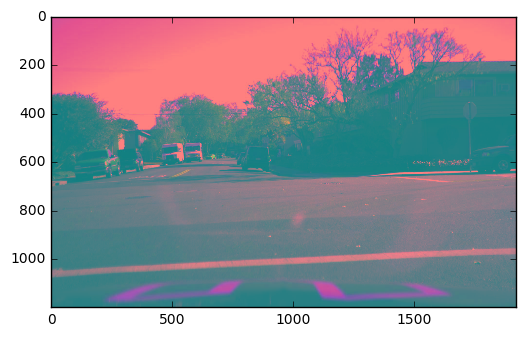

RGB


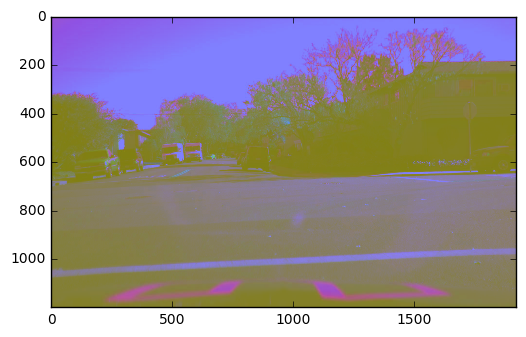

HLS


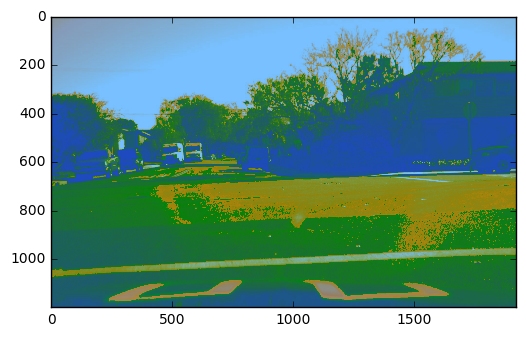

HSV


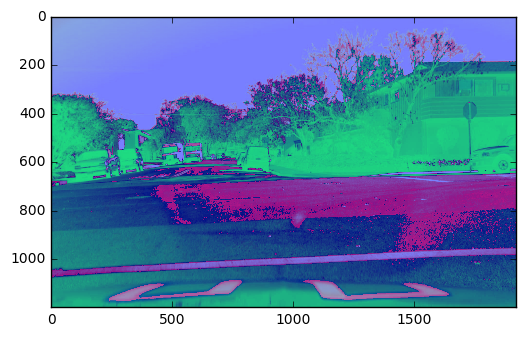

In [14]:
imgRow = 512
imgCol = 768
dataInfo =dataFile
                        
row = 0#np.random.randint(len(dataInfo))
fileName = dataInfo['Frame'][row]
print(fileName)
img = cv2.imread(fileName)
print("YCR")
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
plt.imshow(img1)
plt.show()
img = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
print("RGB")
plt.imshow(img)
plt.show()
print("HLS")
img1 = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
plt.imshow(img1)
plt.show()

print("HSV")
img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
plt.imshow(img)
plt.show()